In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [64]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab_datasets/PlantVillage",
    #seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=5
)

Found 2162 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

1081

In [39]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 0 0 1 0 1 2 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 2]


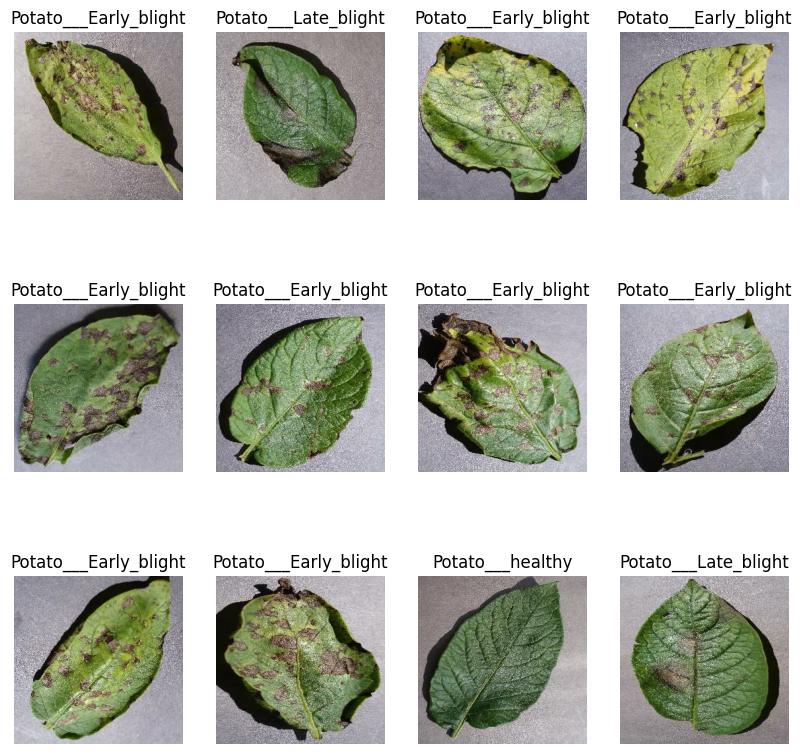

In [40]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

864.8000000000001

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

1027

In [10]:

val_size=0.1
len(dataset)*val_size

108.10000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

1021

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

864

In [16]:
len(val_ds)

108

In [17]:
len(test_ds)

109

#Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = ( None,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
864/864 [==============================] - 539s 26ms/step - loss: 0.9115 - accuracy: 0.5041 - val_loss: 0.9560 - val_accuracy: 0.4583
Epoch 2/30
864/864 [==============================] - 18s 20ms/step - loss: 0.9126 - accuracy: 0.4763 - val_loss: 0.8849 - val_accuracy: 0.5880
Epoch 3/30
864/864 [==============================] - 18s 20ms/step - loss: 0.7345 - accuracy: 0.7020 - val_loss: 0.7318 - val_accuracy: 0.7130
Epoch 4/30
864/864 [==============================] - 19s 21ms/step - loss: 0.6293 - accuracy: 0.7494 - val_loss: 0.7925 - val_accuracy: 0.7176
Epoch 5/30
864/864 [==============================] - 18s 20ms/step - loss: 0.5449 - accuracy: 0.7755 - val_loss: 0.7527 - val_accuracy: 0.7824
Epoch 6/30
864/864 [==============================] - 18s 20ms/step - loss: 0.5071 - accuracy: 0.8073 - val_loss: 0.5434 - val_accuracy: 0.8194
Epoch 7/30
864/864 [==============================] - 19s 21ms/step - loss: 0.4581 - accuracy: 0.8368 - val_loss: 0.5432 - val_accuracy

In [26]:
scores = model.evaluate(test_ds)

109/109 [==============================] - 5s 5ms/step - loss: 0.1954 - accuracy: 0.9220


# Plotting the Accuracy and Loss Curves

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 864}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
len(history.history['loss'])

30

In [31]:
history.history['loss'][:5]

[0.9115332961082458,
 0.9125949144363403,
 0.7344664335250854,
 0.6293007731437683,
 0.5448580980300903]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [33]:
EPOCHS=30

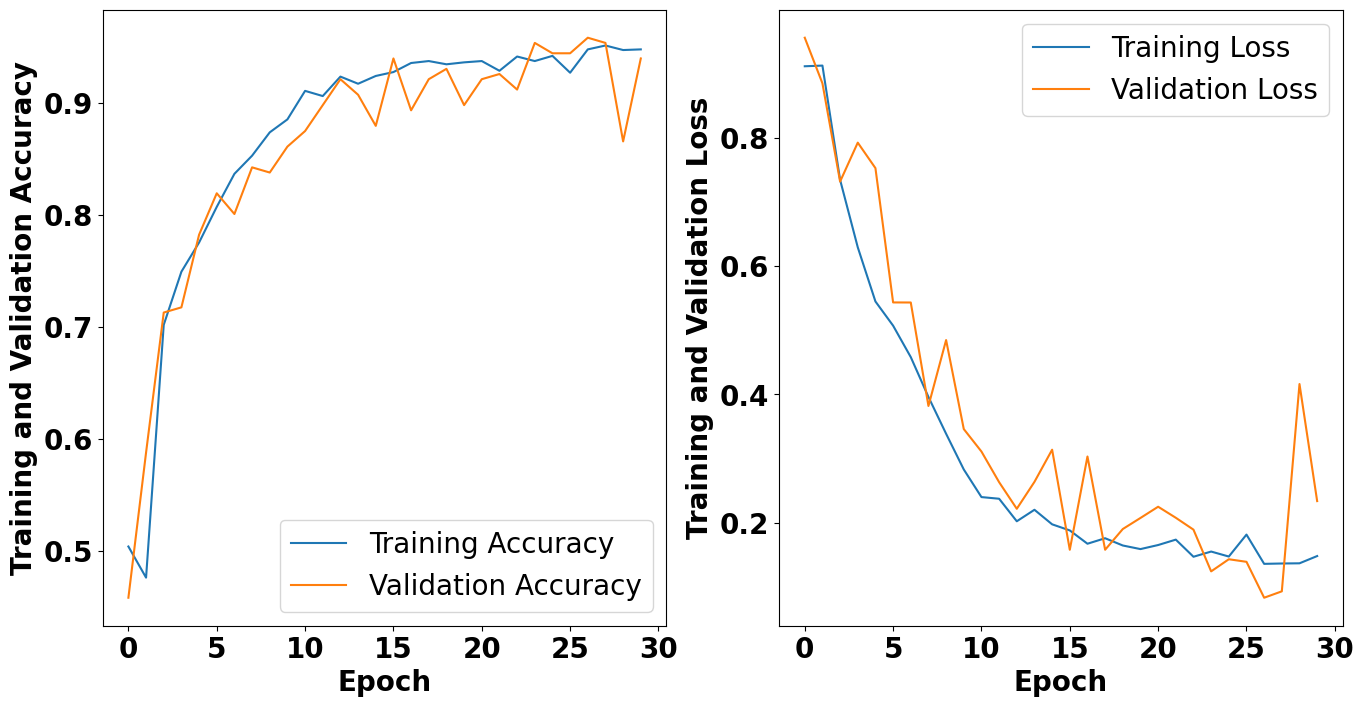

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.ylabel('Training and Validation Accuracy', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=20, fontweight='bold')
plt.legend(loc='lower right',fontsize=20)
from pylab import *

fontsize = 20
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.ylabel('Training and Validation Loss', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=20, fontweight='bold')
plt.legend(loc='upper right',fontsize=20)
from pylab import *

fontsize = 20
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.savefig('/content/drive/MyDrive/capstone/forecast/classification/8.pdf', dpi=300)
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 19ms/step
predicted label: Potato___Early_blight


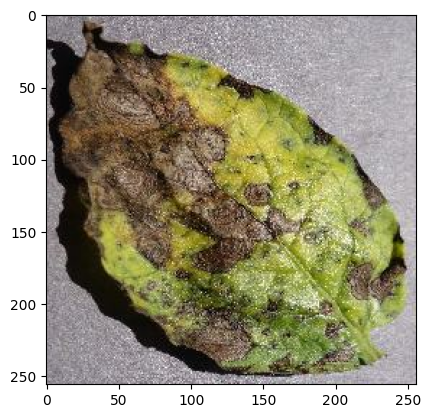

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 61ms/step


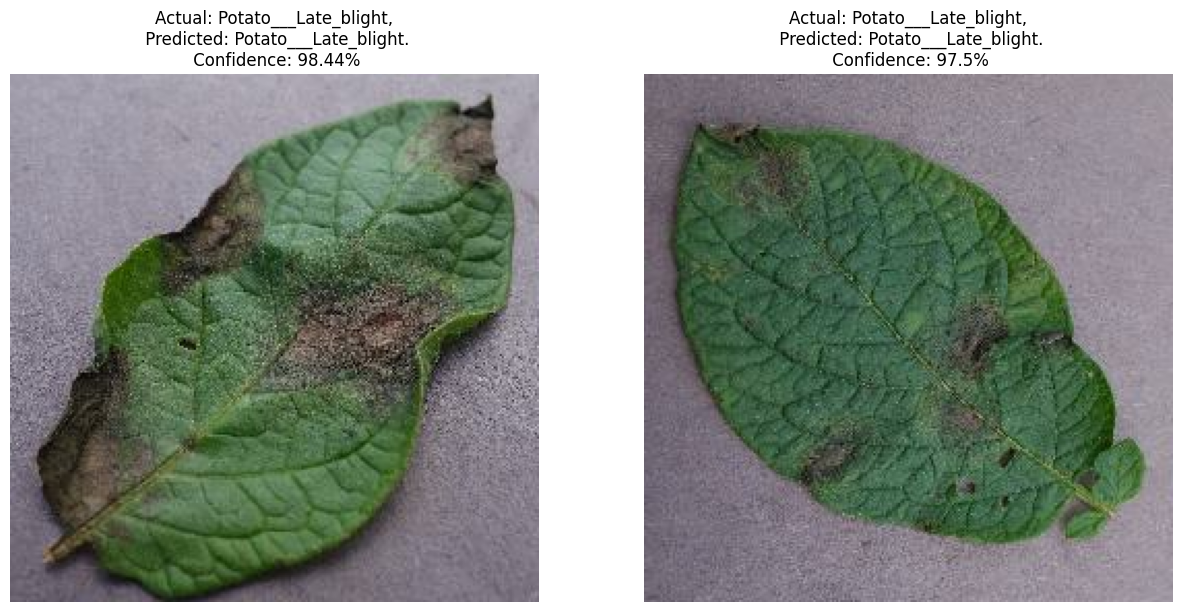

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")